# Can Synthetic Data Replace Real Data

### Goal
The goal of this project is to rigorously evaluate whether synthetic tabular data can replace real data for supervised learning tasks. The primary contribution is empirical: identifying when synthetic data matches/supplements/fails to replace real data.

### Core question
Under what conditions does training on synthetic tabular data achieve comparable performance to training on real tabular data?

## Imports and data loading

In [ ]:
# Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn methods and classes
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score # For AUPRC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

 # For SMOTE
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTEN, SMOTENC

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# For DatasetMetaData
from dataclasses import dataclass

# For displaying pipelines side by side
from IPython.display import display, HTML

In [29]:
gimme_some_credit_train = pd.read_csv("datasets/cs-training.csv")
default_credit_df = pd.read_csv("datasets/UCI_Credit_Card.csv")
adult_census_income_df = pd.read_csv("datasets/adult.csv")

## Exploratory Data Analyses

### Give Me Some Credit EDA
Note that this is not the dataset proposed in the original paper. That dataset was a replica of a competition, which was in turn a subset of another competition's data. This dataset is a copy of the orgininal competition's data.

Note that `SeriousDlqin2yrs` is the target feature, thus is having no values in
the `test` DataFrame.

In [30]:
gimme_some_credit_train.drop('Unnamed: 0', axis='columns', inplace=True)
gimme_some_credit_train.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [31]:
gimme_some_credit_train.info()

<class 'pandas.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtypes: float64(

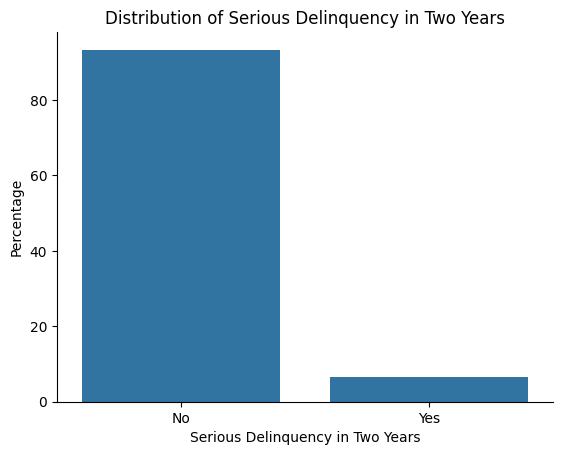

In [32]:
ax = sns.countplot(x='SeriousDlqin2yrs',
                   data=gimme_some_credit_train,
                   stat='percent');
ax.set_title('Distribution of Serious Delinquency in Two Years')
ax.set_xlabel('Serious Delinquency in Two Years');
ax.set_ylabel('Percentage');
ax.set_xticks([0, 1]);
ax.set_xticklabels(['No', 'Yes']);
sns.despine()

In [33]:
gimme_some_credit_train[['SeriousDlqin2yrs', 'NumberOfDependents']].groupby('SeriousDlqin2yrs').value_counts()

SeriousDlqin2yrs  NumberOfDependents
0                 0.0                   81807
                  1.0                   24381
                  2.0                   17938
                  3.0                    8646
                  4.0                    2565
                  5.0                     678
                  6.0                     134
                  7.0                      46
                  8.0                      22
                  9.0                       5
                  10.0                      5
                  20.0                      1
                  13.0                      1
1                 0.0                    5095
                  1.0                    1935
                  2.0                    1584
                  3.0                     837
                  4.0                     297
                  5.0                      68
                  6.0                      24
                  7.0                      

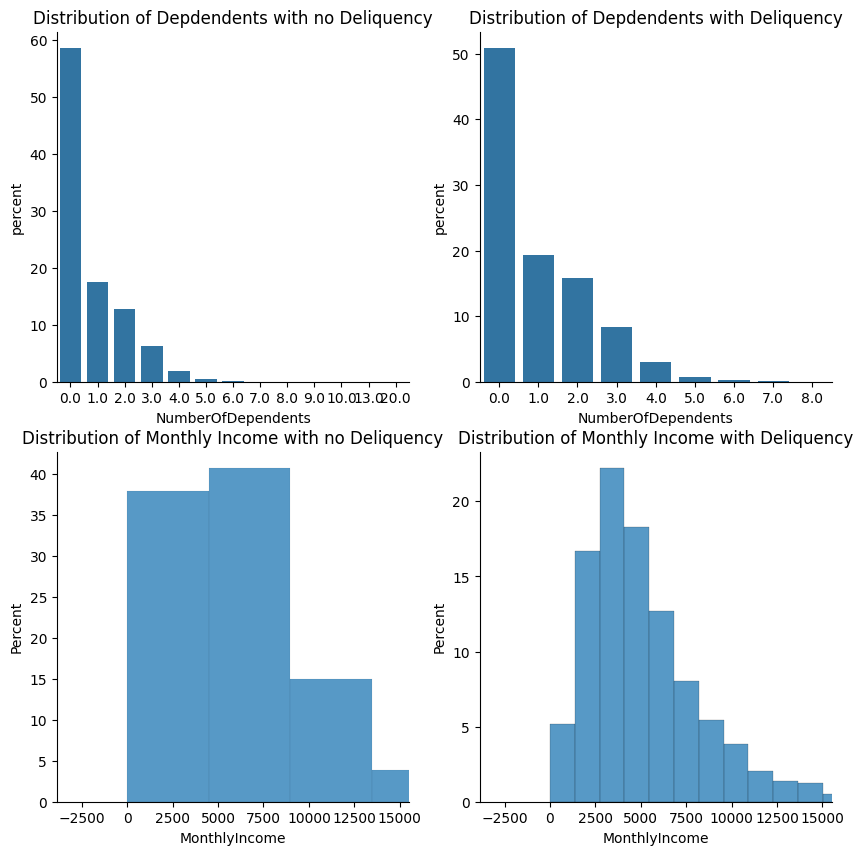

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

sns.countplot(
    data=gimme_some_credit_train[gimme_some_credit_train['SeriousDlqin2yrs'] == 0],
    x='NumberOfDependents',
    stat='percent',
    ax=ax[0, 0]
);

sns.countplot(
    data=gimme_some_credit_train[gimme_some_credit_train['SeriousDlqin2yrs'] == 1],
    x='NumberOfDependents',
    stat='percent',
    ax=ax[0, 1]
);

# Monthly income varies too widely. Let's find outliers
q1, q3 = gimme_some_credit_train['MonthlyIncome'].quantile(0.25), gimme_some_credit_train['MonthlyIncome'].quantile(0.75)
iqr = q3 - q1
low_val, high_val = q1 - 1.5 * iqr, q3 + 1.5 * iqr

sns.histplot(
    data=gimme_some_credit_train[gimme_some_credit_train['SeriousDlqin2yrs'] == 0],
    x='MonthlyIncome',
    stat='percent',
    ax=ax[1, 0]
);

sns.histplot(
    data=gimme_some_credit_train[gimme_some_credit_train['SeriousDlqin2yrs'] == 1],
    x='MonthlyIncome',
    stat='percent',
    ax=ax[1, 1]
);

ax[0, 0].set_title('Distribution of Depdendents with no Deliquency')
ax[0, 1].set_title('Distribution of Depdendents with Deliquency')
ax[1, 0].set_title('Distribution of Monthly Income with no Deliquency')
ax[1, 1].set_title('Distribution of Monthly Income with Deliquency')

# Limit histograms to ignore outliers

ax[1, 0].set_xlim(low_val, high_val)
ax[1, 1].set_xlim(low_val, high_val)

sns.despine();

**Findings:** Our training data had two features which have missing values:
* `NumberOfDependents`
* `MonthlyIncome`

Based on visual inspection, there does not seem to be a correlation between deliquency and the two features. However, statistical testing should be done to confirm this.

Median imputation seems to be appropiate here.

### Default of Credit Clients EDA

In [35]:
default_credit_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [36]:
default_credit_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   30000 non-null

**Findings**: The Default of Credit Clients dataset has no missing values.

### Adult Census Income EDA

In [37]:
adult_census_income_df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [38]:
adult_census_income_df.info()

<class 'pandas.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             32561 non-null  int64
 1   workclass       32561 non-null  str  
 2   fnlwgt          32561 non-null  int64
 3   education       32561 non-null  str  
 4   education.num   32561 non-null  int64
 5   marital.status  32561 non-null  str  
 6   occupation      32561 non-null  str  
 7   relationship    32561 non-null  str  
 8   race            32561 non-null  str  
 9   sex             32561 non-null  str  
 10  capital.gain    32561 non-null  int64
 11  capital.loss    32561 non-null  int64
 12  hours.per.week  32561 non-null  int64
 13  native.country  32561 non-null  str  
 14  income          32561 non-null  str  
dtypes: int64(6), str(9)
memory usage: 3.7 MB


**Findings**: The Adult Census Income dataset has no missing values.

## Set-up, Splitting, Preprocessing, and Cross-Validation
As per sections 2.1, 2.2, and 2.3 of the research protocol document:

1. **Set-up:** We study supervised classification under three training regimes: real-only, synthetic-only, and mixed real-plus-synthetic training. All evaluations are performed on real data that is never used during synthetic data generation.

2. **Splitting:** Each dataset is split into a held-out test set (20%) and a development set (80%). Model selection and evaluation on the development set are performed using repeated stratified K-fold cross-validation. All reported results are averaged across folds and repetitions.

3. **Preprocessing:** Numerical features are standardized using statistics computed on the training portion of each fold. Categorical features are encoded using one-hot encoding. Missing values are imputed using simple strategies (median for numerical features, mode for categorical features). All preprocessing steps are fit exclusively on training data within each fold.



### Set-up

We'll want to encapsulate all the info about our datasets (num cols, cat cols, X_train, X_test, etc in one easy place. This will allow for:
* Decluttering of variable names
* Type-hinting
* Future Iterability

We perform this with the below class. We set up info for experiments first.

In [39]:
TEST_PROPORTION, DEVELOPMENT_PROPORTION = 0.8, 0.2
SPLITS, REPEATS = 5, 5

# TODO: Synthetic methods and Data Regimes (3.3 and 3.5)

regimes = ['real', 'synthetic', 'mixed']
models = [LogisticRegression(random_state=42),
          DecisionTreeClassifier(random_state=42),
          # Commented out as of now because it takes forever to train
          # RandomForestClassifier(random_state=42)
          ]

In [61]:
@dataclass
class DatasetMetadata:
  name: str
  dataset: pd.DataFrame
  target_feature_name: str
  num_feature_names: list | str
  cat_feature_names: list | str

  # Initialize all to None
  X_train: pd.DataFrame = None
  X_test: pd.DataFrame = None
  y_train: pd.DataFrame = None
  y_test: pd.DataFrame = None

  def set_splits(self, test_size=0.2, random_state=42) -> None:
    self.X = self.dataset[self.num_feature_names + self.cat_feature_names].copy()
    self.y = self.dataset[self.target_feature_name].copy()

    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
        self.X, self.y,
        test_size=test_size,
        stratify=self.y,
        random_state=random_state
    )

### Splitting
We store instances of our dataset metadata in a list

In [41]:
credit_metadataset = DatasetMetadata(
    name = "Give Me Some Credit",
    dataset = gimme_some_credit_train,
    target_feature_name = "SeriousDlqin2yrs",
    num_feature_names = gimme_some_credit_train.columns.drop(
        "SeriousDlqin2yrs").to_list(),
    cat_feature_names = []
)

default_metadataset = DatasetMetadata(
    name = "Default of Credit Clients",
    dataset = default_credit_df,
    target_feature_name = "default.payment.next.month",
    # Note that ID is an irrelevant variable, and shouldn't be included.
    # default.payment.next.month is the target feature
    num_feature_names = default_credit_df.drop(
        columns=["ID", "SEX", "EDUCATION", "MARRIAGE",
                    "default.payment.next.month"]).columns.to_list(),
    cat_feature_names = ["SEX", "EDUCATION", "MARRIAGE"]
)

census_metadataset = DatasetMetadata(
    name = "Adult Census Income",
    dataset = adult_census_income_df,
    target_feature_name = "income",
    # On the `fnlwgt` feature (final weight)
    # From https://www.kaggle.com/datasets/uciml/adult-census-income/discussion/32698
    # "Its a weight assigned by the Census Bureau. **The idea is that if two
    # samples have the same(or similar) fnlwgt they have similar
    # characteristics, demographically speaking...but it is not standardized
    # across states."
    #
    # Decision: drop variable
    num_feature_names = ["age", "education.num", "capital.gain",
                            "capital.loss", "hours.per.week"],
    cat_feature_names = ["workclass", "education", "marital.status",
                            "occupation", "relationship", "race", "sex",
                            "native.country"]
)

metadatasets_list = [credit_metadataset, default_metadataset, census_metadataset]

To test we have coverage of the columns, the differences should be nuisance features

In [42]:
for instance in metadatasets_list:
  col_names = pd.Index(instance.num_feature_names + \
                       instance.cat_feature_names + \
                       [instance.target_feature_name])
  display(instance.dataset.columns.difference(col_names))


Index([], dtype='str')

Index(['ID'], dtype='str')

Index(['fnlwgt'], dtype='str')

### Preprocessing

In [43]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
     ('standardize', StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
     ('encode', OneHotEncoder(handle_unknown='ignore', drop='if_binary'))
])

def preprocess(num_cols: list[str], cat_cols: list[str]) -> ColumnTransformer:
  """
  Create a ColumnTransformer for our data

  Args:
    num_cols (list of str): List of numerical column names to be
            imputed (median) and standardized.
    cat_cols (list of str): List of categorical column names to be
        imputed (most frequent) and one-hot encoded.

  Returns:
    ColumnTransformer: A preprocessor which imputes via median then standardizes
    numerical columns and imputes via mode then one-hot encodes categorical
    columns.
  """

  preprocessor = ColumnTransformer(transformers=[
      ('cat', cat_pipeline, cat_cols),
      ('num', num_pipeline, num_cols)
  ])

  return preprocessor

### Cross-Validation

#### **Step 1** for week 3: We'll use the gimme some credit dataset.

As done above, we have defined a dataclass to keep track of holdout and development sets, target and input features.

We initialize this below.

In [71]:
RANDOM_SEED = 42

credit_metadataset.set_splits(test_size=0.2, random_state=RANDOM_SEED)

#### **Step 2** for week 3: Create the holdout test once and don't touch it
* 80% development set (for repeated CV)
* 20% final holdout test set (do not use for SMOTE, tuning, or model selection)

In [72]:
development_X, final_holdout_X = credit_metadataset.X_train, credit_metadataset.X_test
development_y, final_holdout_y = credit_metadataset.y_train, credit_metadataset.y_test

# Check that X and y are the same size
if development_X.shape[0] != development_y.shape[0]:
    raise ValueError(f"I messed up the shapes! number of X rows: {development_X.shape[0]} \
number of y rows: {development_y.shape[0]}")

total_size = development_X.shape[0] + final_holdout_X.shape[0]

if development_X.shape[0] / total_size != 0.8:
    raise ValueError(f"I messed up the train-test split proportion! number of X rows: \
{development_X.shape[0]}, total size: {total_size}")

#### **Step 3** for week 3: Set up repeated stratified cross-validation (the core of leakage safety)
* Use RepeatedStratifiedKFold (example: 5 folds by 2 repeats).
* Fix random seeds so results are reproducible.
* Important: every fold must have its own training-only preprocessing and training-only resampling.

In [73]:
FOLDS, REPEATS = 5, 2

cv_strategy = RepeatedStratifiedKFold(n_splits=FOLDS, n_repeats=REPEATS,
                                      random_state=RANDOM_SEED)
cv_strategy

RepeatedStratifiedKFold(n_repeats=2, n_splits=5, random_state=42)

#### **Step 4** for week 3: Build **one** leakage-safe pipeline per model using an imblearn Pipeline
The key rule: SMOTE must happen ONLY on the training fold, and only after any transformations that affect distance.
For Week 3 (numeric dataset), use this pipeline structure:
* Imputation (median)
* Scaling (standardize)
* Resampling (None vs RandomOverSampler vs SMOTE)
* Model

Do NOT:
* Fit the scaler/imputer on the full dataset
* Apply SMOTE before splitting into folds
* Apply SMOTE to the validation fold or holdout set




In [74]:
base_credit_pipeline = Pipeline(steps=[
                            ("impute", SimpleImputer(strategy="median")),
                            ("standardize", StandardScaler())
                        ])

base_credit_pipeline

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('impute', ...), ('standardize', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"missing_values missing_values: int, float, str, np.nan, None or pandas.NA, default=np.nanThe placeholder for the missing values. All occurrences of`missing_values` will be imputed. For pandas' dataframes withnullable integer dtypes with missing values, `missing_values`can be set to either `np.nan` or `pd.NA`.",nan
,"strategy strategy: str or Callable, default='mean'The imputation strategy.- If ""mean"", then replace missing values using the mean along each column. Can only be used with numeric data.- If ""median"", then replace missing values using the median along each column. Can only be used with numeric data.- If ""most_frequent"", then replace missing using the most frequent value along each column. Can be used with strings or numeric data. If there is more than one such value, only the smallest is returned.- If ""constant"", then replace missing values with fill_value. Can be used with strings or numeric data.- If an instance of Callable, then replace missing values using the scalar statistic returned by running the callable over a dense 1d array containing non-missing values of each column... versionadded:: 0.20 strategy=""constant"" for fixed value imputation... versionadded:: 1.5 strategy=callable for custom value imputation.",'median'
,"fill_value fill_value: str or numerical value, default=NoneWhen strategy == ""constant"", `fill_value` is used to replace alloccurrences of missing_values. For string or object data types,`fill_value` must be a string.If `None`, `fill_value` will be 0 when imputing numericaldata and ""missing_value"" for strings or object data types.",None
,"copy copy: bool, default=TrueIf True, a copy of X will be created. If False, imputation willbe done in-place whenever possible. Note that, in the following cases,a new copy will always be made, even if `copy=False`:- If `X` is not an array of floating values;- If `X` is encoded as a CSR matrix;- If `add_indicator=True`.",True
,"add_indicator add_indicator: bool, default=FalseIf True, a :class:`MissingIndicator` transform will stack onto outputof the imputer's transform. This allows a predictive estimatorto account for missingness despite imputation. If

#### **Step 5** for week3: Implement the three resampling conditions (your baseline rows)
For each model, run all three:
* None (no resampling)
* Random oversampling (RandomOverSampler)
* SMOTE (default k_neighbors=5 is fine for now; no tuning yet)

In [48]:
cv_strategy = RepeatedStratifiedKFold(n_splits=SPLITS, n_repeats=REPEATS,
                                      random_state=42)

# Dict to store results of cv tests
results = {}

for model in models:
  model_name = model.__class__.__name__

  for instance in metadatasets_list:
    display(f'Currently working on {instance.name} training with {model_name}...')
    preprocessor = preprocess(num_cols=instance.num_feature_names,
                              cat_cols=instance.cat_feature_names)

    model_pipeline = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("clf", model)
    ])

    scores = cross_val_score(
        model_pipeline,
        instance.X_train,
        instance.y_train,
        scoring = 'roc_auc',
        cv=cv_strategy,
        n_jobs=-1
    )

    mean_score = np.mean(scores)

    if instance.name not in results:
            results[instance.name] = {}
    results[instance.name][model_name] = mean_score

pd.DataFrame(results)

'Currently working on Give Me Some Credit training with LogisticRegression...'

c:\Users\zeeri\OneDrive\Documents\GSU\Spring 2026\CSC 4352\Synthetic-Data-Analysis\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


'Currently working on Default of Credit Clients training with LogisticRegression...'

InvalidParameterError: The 'X' parameter of cross_val_score must be an array-like or a sparse matrix. Got None instead.

## Week 3 - Default of Credit Card Clients